<a href="https://colab.research.google.com/github/SaifEleslamElgalaly/food-101-classification/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading and Preprocessing Dataset

In [1]:
# Mount Google Drive and copy dataset if needed
from google.colab import drive
import os, shutil, stat, collections
from collections import defaultdict

In [2]:
drive.mount('/content/drive')
!cp -r "/content/drive/MyDrive/food-101" "/content/"
data_path = "/content/food-101"

Mounted at /content/drive


In [4]:
# ضغط مجلد food-101 كملف zip
!zip -r /content/food-101.zip /content/food-101


Scanning files ..... .......
  adding: content/food-101/ (stored 0%)
  adding: content/food-101/license_agreement.txt (deflated 37%)
  adding: content/food-101/README.txt (deflated 50%)
  adding: content/food-101/meta/ (stored 0%)
  adding: content/food-101/meta/train.txt (deflated 77%)
  adding: content/food-101/meta/train.json (deflated 80%)
  adding: content/food-101/meta/test.txt (deflated 76%)
  adding: content/food-101/meta/test.json (deflated 78%)
  adding: content/food-101/meta/labels.txt (deflated 44%)
  adding: content/food-101/meta/classes.txt (deflated 48%)
  adding: content/food-101/train/ (stored 0%)
  adding: content/food-101/train/baklava/ (stored 0%)
  adding: content/food-101/train/baklava/2397226.jpg (deflated 0%)
  adding: content/food-101/train/baklava/2135376.jpg (deflated 0%)
  adding: content/food-101/train/baklava/453550.jpg (deflated 3%)
  adding: content/food-101/train/baklava/2461257.jpg (deflated 0%)
  adding: content/food-101/train/baklava/3676448.jpg (def

In [3]:
# 1) استيراد المكتبات
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [4]:
# 3) تجهيز التوازي (multiprocessing)
num_processes = 6
pool = mp.Pool(processes=num_processes)

In [5]:
# 4) بناء خريطة الكلاسات
class_to_ix, ix_to_class = {}, {}
with open(os.path.join(data_path, 'meta', 'classes.txt'), 'r') as f:
    classes = [l.strip() for l in f]
    class_to_ix = {c:i for i,c in enumerate(classes)}
    ix_to_class = {i:c for i,c in enumerate(classes)}
sorted_class_to_ix = collections.OrderedDict(sorted(class_to_ix.items()))


In [6]:
# 5) تقسيم الصور إلى مجلدات train / test (مرة واحدة)
def generate_dir_file_map(path_txt):
    d = defaultdict(list)
    with open(path_txt) as f:
        for line in f:
            dir_name, fname = line.strip().split('/')
            d[dir_name].append(fname + '.jpg')
    return d

train_map = generate_dir_file_map(os.path.join(data_path, 'meta', 'train.txt'))
test_map  = generate_dir_file_map(os.path.join(data_path, 'meta', 'test.txt'))

def copytree(src, dst, ignore_map):
    if not os.path.exists(dst):
        os.makedirs(dst)
    for class_name in os.listdir(src):
        sdir = os.path.join(src, class_name)
        ddir = os.path.join(dst, class_name)
        os.makedirs(ddir, exist_ok=True)
        for img_name in os.listdir(sdir):
            keep = img_name in ignore_map[class_name]
            if keep:
                shutil.copy(os.path.join(sdir, img_name), os.path.join(ddir, img_name))

if not os.path.isdir(os.path.join(data_path, 'train')):
    copytree(os.path.join(data_path, 'images'), os.path.join(data_path, 'train'), train_map)
if not os.path.isdir(os.path.join(data_path, 'test')):
    copytree(os.path.join(data_path, 'images'), os.path.join(data_path, 'test'), test_map)


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation للـ Train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation/Test ما نعمللهمش Augmentation بس نعمل Rescale
test_datagen = ImageDataGenerator(rescale=1./255)

# توليد الداتا أثناء التدريب
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_path, 'train'),
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

valid_generator = test_datagen.flow_from_directory(
    os.path.join(data_path, 'test'),
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


Visualization Tools

In [9]:
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.0 MB/s eta 0:00:00


In [10]:
import random
from PIL import Image
from ipywidgets import interact # Import interact from ipywidgets



@interact(n_class=sorted_class_to_ix)
def show_random_images_of_class(n_class=0):
    class_name = ix_to_class[n_class]
    folder_path = os.path.join(data_path, 'train', class_name)  # للتدريب

    all_images = os.listdir(folder_path)
    chosen_images = random.sample(all_images, min(len(all_images), 32))

    nrows, ncols = 4, 8
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))
    fig.suptitle(f"Class: {class_name}", fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < len(chosen_images):
            img_path = os.path.join(folder_path, chosen_images[i])
            img = Image.open(img_path)
            ax.imshow(img)
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='n_class', options=OrderedDict([('apple_pie', 0), ('baby_back_ribs'…

In [11]:
@interact(n_class=sorted_class_to_ix)
def show_random_images_of_class(n_class=0):
    class_name = ix_to_class[n_class]
    folder_path = os.path.join(data_path, 'test', class_name)

    all_images = os.listdir(folder_path)
    chosen_images = random.sample(all_images, min(len(all_images), 32))

    nrows, ncols = 4, 8
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))
    fig.suptitle(f"Class: {class_name}", fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < len(chosen_images):
            img_path = os.path.join(folder_path, chosen_images[i])
            img = Image.open(img_path)
            ax.imshow(img)
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='n_class', options=OrderedDict([('apple_pie', 0), ('baby_back_ribs'…

Image Augmentation

In [12]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import random
import os

# عدد الكلاسات
n_classes = len(sorted_class_to_ix)

# إعداد الـ train_datagen مع Augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# إعداد الـ validation/test datagen (بدون augmentations)
test_datagen = ImageDataGenerator(rescale=1./255)

# إعداد الـ Generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_path, 'train'),
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

valid_generator = test_datagen.flow_from_directory(
    os.path.join(data_path, 'test'),
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


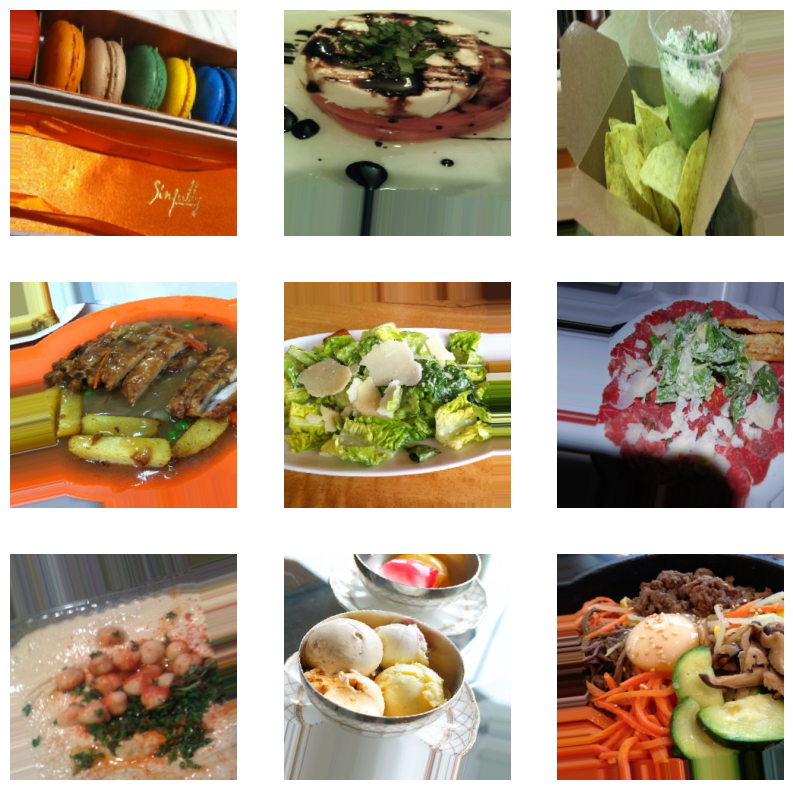

In [13]:
# عرض صور من الـ train_generator مع Augmentation
def plot_augmented_images(generator):
    x_batch, y_batch = next(generator)
    plt.figure(figsize=(10,10))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(x_batch[i])
        plt.axis('off')
    plt.show()

plot_augmented_images(train_generator)


Training

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, AveragePooling2D, Input
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.regularizers import l2
import os


In [15]:

# تأكد إنك بتستخدم كرت شاشة لو متاح
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [16]:
# Clear Session
tf.keras.backend.clear_session()


In [17]:
# تحميل InceptionV3 بدون الطبقة الأخيرة
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))

# بناء الطبقات الجديدة
x = base_model.output
x = AveragePooling2D(pool_size=(8,8))(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
predictions = Dense(
    n_classes,
    activation='softmax',
    kernel_initializer='glorot_uniform',
    kernel_regularizer=l2(0.0005)
)(x)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# بناء الموديل النهائي
model = Model(inputs=base_model.input, outputs=predictions)

# إعداد الـ Optimizer
opt = SGD(learning_rate=0.01, momentum=0.9)

# Compile Model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_cb = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', verbose=1)
csv_logger_cb = CSVLogger('training_log.csv')
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Learning Rate Scheduler
def schedule(epoch):
    if epoch < 15:
        return 0.01
    elif epoch < 28:
        return 0.002
    else:
        return 0.0004

lr_scheduler_cb = LearningRateScheduler(schedule)

# التدريب
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=32,
    verbose=1,
    callbacks=[lr_scheduler_cb, csv_logger_cb, checkpoint_cb, early_stopping_cb]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/32


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 299, 299, 3))
  warnings.warn(msg)


 136/2368 ━━━━━━━━━━━━━━━━━━━━ 16:54:26 27s/step - accuracy: 0.0760 - loss: 4.4544